In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pickle

%matplotlib inline

## Basic EDA Data and Plots

In [3]:
with open ('30OCT17_finalfitmodelsv2/cleaned_df.pkl', 'rb') as f:
    cleaned_data = pickle.load(f)

In [4]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16978 entries, 0 to 16988
Data columns (total 28 columns):
PersonID             16978 non-null int64
EventID              16978 non-null int64
Gender               16978 non-null object
Distance             16978 non-null object
Total fee            16978 non-null float64
Payment method       13482 non-null object
Street Address       14062 non-null object
City                 15232 non-null object
State/Province       16087 non-null object
Zip Code             14978 non-null object
Country              15796 non-null object
Contact              16978 non-null object
Tshirt               16978 non-null object
Hoodie               16978 non-null object
Event_Name           16978 non-null object
Event_Date           16978 non-null datetime64[ns]
MergeoEvent          16978 non-null bool
EventTypeID          16978 non-null int64
EventType            16978 non-null object
SeriesID             16978 non-null float64
Age2                 16978

In [5]:
unique_personIDs = cleaned_data['PersonID'].unique()
unique_eventIDs = cleaned_data['EventID'].unique()

In [6]:
print ('Total Number of Users: {}'.format(len(unique_personIDs)))
print ('Total Number of Events: {}'.format(len(unique_eventIDs)))
print ('Total Number of Participations {}'.format(len(cleaned_data)))

Total Number of Users: 10764
Total Number of Events: 86
Total Number of Participations 16978


In [7]:
print ('Total Possible Participations: {}'.format(len(unique_personIDs) * len(unique_eventIDs)))

Total Possible Participations: 925704


In [8]:
print ('Participant Sparsity: {}%'.format(round((1 - len(cleaned_data) / 
                                                 float(len(unique_personIDs) * len(unique_eventIDs)))*100)))

Participant Sparsity: 98.0%


### Participation per Event EDA

In [9]:
part_per_event = cleaned_data.groupby('EventID')['PersonID'].count()

In [10]:
print ('Min Event Size {}, Max Event Size {}'.format(
    min(part_per_event), max(part_per_event)))

Min Event Size 34, Max Event Size 592


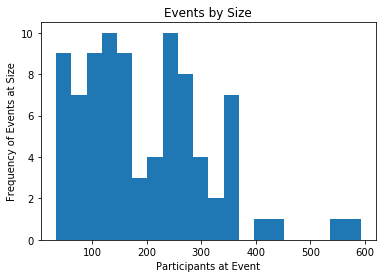

In [11]:
plt.hist(part_per_event, bins=20);
plt.title('Events by Size');
plt.xlabel('Participants at Event');
plt.ylabel('Frequency of Events at Size');

In [12]:
largest_events = cleaned_data.groupby('EventID').count()[['EventType']].sort_values(
                  'EventType', ascending=False)
largest_events.reset_index(inplace=True)
largest_events = pd.merge(largest_events, cleaned_data, on='EventID')
largest_events = largest_events[['EventID', 'EventType_y', 'EventType_x', 'Event_Name', 'SeriesID', 'Event_Date']]
largest_events.drop_duplicates(subset='EventID', inplace=True)
largest_events.reset_index(drop=True, inplace=True)
largest_events.rename(columns = {'EventType_x' : 'Attendance'}, inplace=True)

In [13]:
largest_events[largest_events['Event_Name']=='Interlaken Icicle Dash'].sort_values('Event_Date', ascending=False)

,EventID,EventType_y,Attendance,Event_Name,SeriesID,Event_Date
23,67,Trail Run,265,Interlaken Icicle Dash,1.0,2017-02-05
7,35,Trail Run,352,Interlaken Icicle Dash,1.0,2016-01-23
20,9,Trail Run,275,Interlaken Icicle Dash,1.0,2015-01-24


In [14]:
largest_events[largest_events['EventID']==79]

,EventID,EventType_y,Attendance,Event_Name,SeriesID,Event_Date
43,79,Trail Run,170,Carkeek Warmer,3.0,2017-07-11


### Events per Participant EDA

In [24]:
events_per_part = cleaned_data.groupby('PersonID')['EventID'].count()

In [25]:
print ('Min Participation Size {}, Max Participation Size {}'.format(
    min(events_per_part), max(events_per_part)))

Min Participation Size 1, Max Participation Size 50


In [26]:
events_per_part.sort_values(inplace=True)

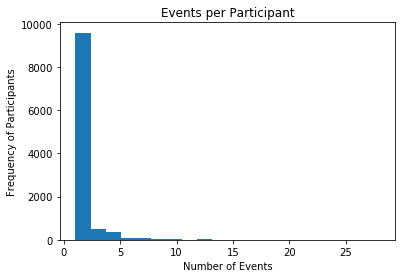

In [27]:
plt.hist(events_per_part.iloc[:10761], bins=20);
plt.title('Events per Participant');
plt.xlabel('Number of Events');
plt.ylabel('Frequency of Participants');

#dropped three rows for the three people with over 30 events to show better granularity for the rest (1673, 1910, 1115)

In [30]:
count = 0
for event in events_per_part:
    if event <=5:
        count += 1
        
print (float(count)/len(events_per_part))

0.972129319955


'Total Participations: 10,764; 10,688 have attended 10 events or less; 8,235 have only attended 1 event'

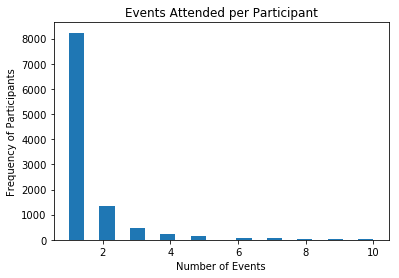

In [19]:
plt.hist(events_per_part.iloc[0:10688], bins=20);
plt.title('Events Attended per Participant');
plt.xlabel('Number of Events');
plt.ylabel('Frequency of Participants');

'Total Participations: 10,764; 10,688 have attended 10 events or less; 8,235 have only attended 1 event'

In [18]:
highest_participants = cleaned_data.groupby('PersonID').count()[['EventType']].sort_values(
                  'EventType', ascending=False)

highest_participants.reset_index(inplace=True)

highest_participants = pd.merge(highest_participants, cleaned_data, on='PersonID')

highest_participants = highest_participants[['PersonID', 'Gender', 'Age2', 'EventType_x']]

highest_participants.drop_duplicates(subset='PersonID', inplace=True)
highest_participants.reset_index(drop=True, inplace=True)
highest_participants.rename(columns = {'EventType_x' : 'Attendance'}, inplace=True)

In [19]:
highest_participants.head(10)

,PersonID,Gender,Age2,Attendance
0,1115,Male,53.0,50
1,1910,Male,46.0,37
2,1673,Female,49.0,34
3,1481,Female,26.0,28
4,729,Female,47.0,28
5,741,Female,29.0,26
6,3267,Female,59.0,26
7,1664,Male,48.0,25
8,3056,Male,36.0,24
9,149,Male,60.0,22


## Fitting ALS Models and Assessing Rank

In [20]:
als_ranks_tune = pd.read_csv('../data/als_ranks_tune.csv')

In [21]:
als_ranks_tune.head(10)

,als_model,alpha,factors,model_rank,popular_rank
0,series,10,5,11.012784,14.605311
1,series,10,10,12.364938,14.605311
2,series,10,30,12.217457,14.605311
3,series,40,5,8.500245,14.605311
4,series,40,10,10.242787,14.605311
5,series,40,30,11.665075,14.605311
6,series,80,5,7.361186,14.605311
7,series,80,10,8.679236,14.605311
8,series,80,30,10.726325,14.605311
9,event_type,10,5,0.000000,0.000000


In [22]:
five_factor = als_ranks_tune[als_ranks_tune['factors'] == 5]
five_factor.reset_index(drop=True, inplace=True)
five_factor

,als_model,alpha,factors,model_rank,popular_rank
0,series,10,5,11.012784,14.605311
1,series,40,5,8.500245,14.605311
2,series,80,5,7.361186,14.605311
3,event_type,10,5,0.000000,0.000000
4,event_type,40,5,0.000000,0.000000
5,event_type,80,5,100.000000,100.000000
6,venue,10,5,14.527180,34.874847
7,venue,40,5,12.802553,34.874847
8,venue,80,5,11.991155,34.874847
9,avg_fee,10,5,19.589791,21.788490


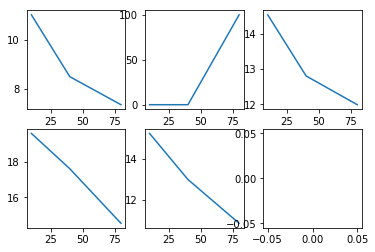

In [23]:
fig, axs = plt.subplots(2, 3)

a = 0
b = 3

for ax in axs.flatten():
    ax.plot(five_factor['alpha'].iloc[a:b], five_factor['model_rank'].iloc[a:b])
    a+=3
    b+=3

In [24]:
five_factor.drop([3, 4, 5], axis=0, inplace=True)
five_factor.reset_index(drop=True, inplace=True)

/Users/ginanuss/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [25]:
five_factor

,als_model,alpha,factors,model_rank,popular_rank
0,series,10,5,11.012784,14.605311
1,series,40,5,8.500245,14.605311
2,series,80,5,7.361186,14.605311
3,venue,10,5,14.527180,34.874847
4,venue,40,5,12.802553,34.874847
5,venue,80,5,11.991155,34.874847
6,avg_fee,10,5,19.589791,21.788490
7,avg_fee,40,5,17.604070,21.788490
8,avg_fee,80,5,14.532785,21.788490
9,avg_miles,10,5,15.270046,29.196071


'Lower rank is more desirable, as it indicates ranking actually attended events closer to the top of the recommendation lists'

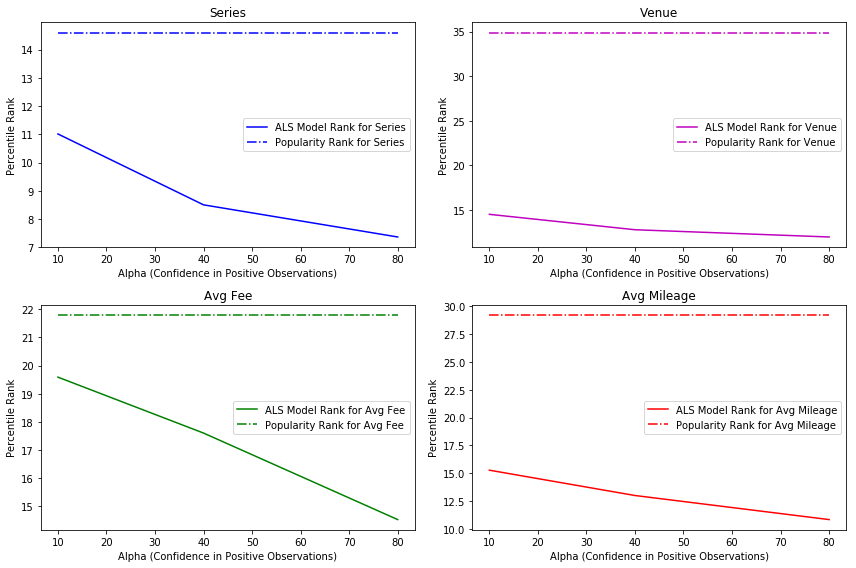

In [26]:
a = 0
b = 3

labels = ['Series', 'Venue', 'Avg Fee', 'Avg Mileage']
colors = ['b', 'm', 'g', 'r']

fig, axs = plt.subplots(2, 2, figsize=(12,8))

for ax, val in zip(axs.flatten(), range(4)):
    ax.plot(five_factor['alpha'].iloc[a:b], five_factor['model_rank'].iloc[a:b], 
                label='ALS Model Rank for {}'.format(labels[val]), c=colors[val])
    ax.hlines(five_factor['popular_rank'].iloc[a:b].mean(), xmin=10, xmax=80, 
               label='Popularity Rank for {}'.format(labels[val]), colors=colors[val], linestyles='dashdot')
    ax.set_xlabel('Alpha (Confidence in Positive Observations)')
    ax.set_ylabel('Percentile Rank');
    ax.set_title('{}'.format(labels[val]))
    ax.legend(loc=7)
    a+=3
    b+=3
    
fig.tight_layout()

fig.set_label('Tuning ALS Recommenders - Rank Varies with Alpha', );

'Lower rank is more desirable, as it indicates ranking actually attended events closer to the top of the recommendation lists'

In [35]:
gb_ranks = pd.read_csv('../data/gb_ranks.csv')

In [36]:
gb_ranks.head(20)

,gb_model,train/val/test,learning_rate,max_depth,n_est,subsample,model_rank,popular_rank
0,base,val,0.10,3.0,100.0,1.0,10.608257,36.005992
1,v2,val,0.01,10.0,1000.0,0.5,13.215035,36.005992
2,v3,val,0.10,5.0,500.0,0.5,12.844999,36.005992
3,v4,val,0.10,3.0,100.0,0.5,10.896491,36.005992
4,v5,val,0.01,3.0,100.0,0.5,7.856947,36.005992
5,v6,val,0.01,5.0,100.0,0.5,8.166665,36.005992
6,v7,val,0.01,3.0,100.0,1.0,7.660948,36.005992
7,v8,val,0.01,3.0,300.0,0.5,9.192136,36.005992
8,v5,test,0.01,3.0,100.0,0.5,18.517768,30.302022
9,v5,trainval,0.01,3.0,100.0,0.5,7.264567,33.199723


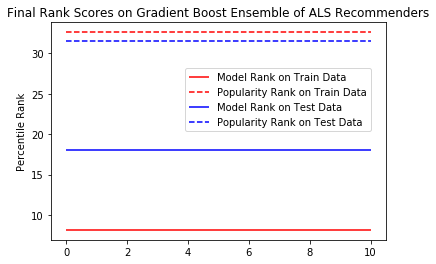

In [37]:
plt.hlines(gb_ranks['model_rank'].iloc[13], xmin=0, xmax=10, label='Model Rank on Train Data', linestyles='solid', 
          color='r')
plt.hlines(gb_ranks['popular_rank'].iloc[13], xmin=0, xmax=10, label='Popularity Rank on Train Data', 
           linestyles='dashed', color='r')
plt.hlines(gb_ranks['model_rank'].iloc[14], xmin=0, xmax=10, label='Model Rank on Test Data', linestyles='solid', 
          color='b')
plt.hlines(gb_ranks['popular_rank'].iloc[14], xmin=0, xmax=10, label='Popularity Rank on Test Data', 
           linestyles='dashed', color='b')

plt.title('Final Rank Scores on Gradient Boost Ensemble of ALS Recommenders');
#plt.xlabel('Number of Events');
plt.ylabel('Percentile Rank');
plt.legend(loc=(.4,.5))